In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Titanic Surviving Predict

This project is from Kaggle: https://www.kaggle.com/c/titanic/overview


#### All following code is 100% from Richard Xue.

## 1. Question Framing

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

Is it possible to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)?

Objective: The models I decide to use to predict are: 
- Feature Engineering

## 2. Loading data

We have 2 datasets: train and test. 
- train.csv contains passenger data, including death or alive
- test.csv contrains passenger data, but we don't know if they are alive or not

#### Variable Explanation

- Survived:      Survival,        0 = No, 1 = Yes
- Pclass:        Ticket class,    1 = 1st, 2 = 2nd, 3 = 3rd
- Sex:           Sex
- Age:           Age,             in years
- SibSp:         # of siblings / spouses aboard the Titanic
- Parch:         # of parents / children aboard the Titanic
- Ticket:       Ticket number
- Fare:          Passenger fare
- Cabin:         Cabin number
- Embarked:      Port of Embarkation,     C = Cherbourg, Q = Queenstown, S = Southampton

In [2]:
original_train = pd.read_csv('train.csv')
print(original_train.shape)
original_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
full_data = original_train.append(test, ignore_index = True)
full_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [5]:
fixed_train = original_train.copy()
fixed_test = test.copy()
full = [fixed_train, fixed_test]

## 3. Variable Exploration

One of the most important question in our prediction is that: which variables have the biggest contribution to the outcome that we are predicting? 

Let's look at our variables.

In [6]:
# FixMe

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [7]:
original_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 3.1 Numerical Variables

### 3.1.1 Age

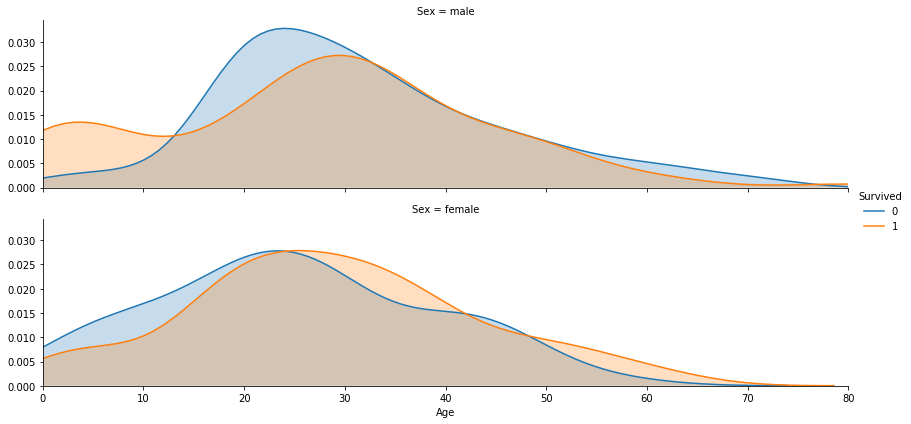

In [8]:
plot_distribution(original_train, var='Age', target='Survived', row='Sex')

### 3.1.2 Fare

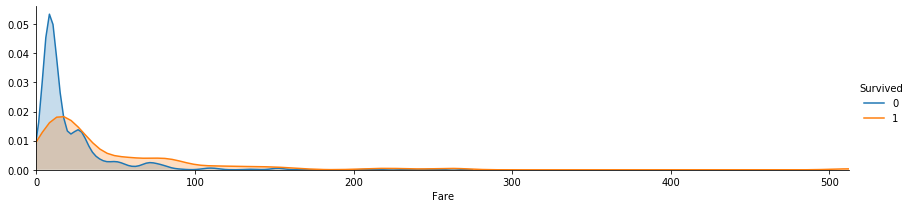

In [9]:
plot_distribution(original_train, var='Fare', target='Survived')

## 3.2 Categorial Variables

### 3.2.1 Embarked

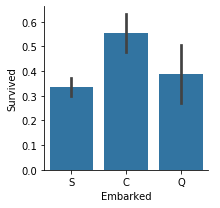

In [10]:
plot_categories(original_train, cat='Embarked', target='Survived')

### 3.2.2 Sex

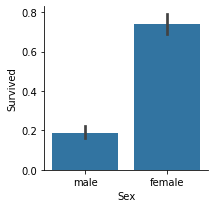

In [11]:
plot_categories(original_train, cat='Sex', target='Survived')

In [12]:
original_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean() \
.sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


### 3.2.3 Pclass

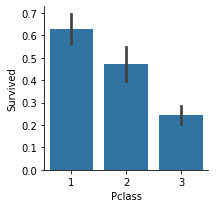

In [13]:
plot_categories(original_train, cat='Pclass', target='Survived')

In [14]:
original_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean() \
.sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### 3.2.4 SibSp

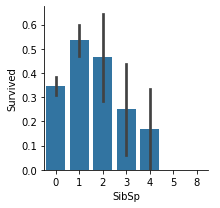

In [15]:
plot_categories(original_train, cat='SibSp', target='Survived')

In [16]:
original_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean() \
.sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


### 3.2.5 Parch

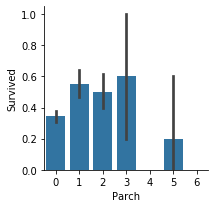

In [17]:
plot_categories(original_train, cat='Parch', target='Survived')

In [18]:
original_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean() \
.sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## 4. Data Cleaning 

## 4.1 One Hot Encoding

In [19]:
# To convert categorial data to numeric data, I choose to use One Hot Encoding.

def ohe_with_dataframe(data, col):
    
    """
    One-hot-encodes given column.
    
    Input: data - target dataframe
            col - target column
            
    Output: dataframe with target column one-hot-encoded
    """
    
    # Initialize DictVec
    vec_enc = DictVectorizer()
    vec_enc.fit(data[[col]].to_dict(orient='records'))

    # Convert categorial data to numerical data array
    col_data = vec_enc.transform(data[[col]].to_dict(orient='records')).toarray()
    
    # Get feature names (unique values in that column)
    col_cats = vec_enc.get_feature_names()
    
    # Create a dataframe with ohe columns
    col = pd.DataFrame(col_data, columns=col_cats)

    # Reset the index to avoid creating empty rows
    data = data.reset_index()
    
    # Combine by INDEX start from 0
    data = pd.concat([data, col], axis=1)
    
    return data

def ohe(data, col):
    
    """
    One-hot-encodes given column.
    
    Input: data - target dataframe
            col - target column
            
    Output: Only ohe-d target column
    """
    
    vec_enc = DictVectorizer()
    vec_enc.fit(data[[col]].to_dict(orient='records'))
    col_data = vec_enc.transform(data[[col]].to_dict(orient='records')).toarray()
    col_cats = vec_enc.get_feature_names()
    col = pd.DataFrame(col_data, columns=col_cats)
    
    return col

ohe_with_dataframe(original_train, 'Embarked').head()
# ohe(original_train, 'Embarked').head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked,Embarked=C,Embarked=Q,Embarked=S
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,0.0,1.0
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.0,1.0,0.0,0.0
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,0.0,1.0
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,0.0,1.0
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,0.0,1.0


In [20]:
# Transform Sex into binary values 0 and 1
for dataset in full:
    try:
        dataset['Sex'] = dataset['Sex'].map( {'male': 0, 'female': 1} ).astype(int)
    except:
        break

full = [fixed_train, fixed_test]
fixed_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


## 4.2 Fill missing values

In [21]:
# We first deal with null values in our dataframe

def null_columns(df):
    """
    Prints the column name if this column contains NaN.
    
    Input: df - target dataframe
    Output: column names
    
    """
    for col in df.columns:
        if df.isna()[col].any():
            print(col, type(col))

print('Train contains NaN in the following columns: ')
null_columns(original_train)

Train contains NaN in the following columns: 
Age <class 'str'>
Cabin <class 'str'>
Embarked <class 'str'>


In [22]:
print('Test contains NaN in the following columns: ')
null_columns(test)

Test contains NaN in the following columns: 
Age <class 'str'>
Fare <class 'str'>
Cabin <class 'str'>


To fill missing values, we can choose to fill random numbers, but there might be too much noise and affecting our model's performance.

To predict more accurate, we can guess the value based on other coorelated values, such as Age, Pclass, and Gender.

In [23]:
# We see multiple columns contain NaN. Let's fix them one by one.

# 1. Age
original_train['Age'].unique() # Check what the data looks like

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

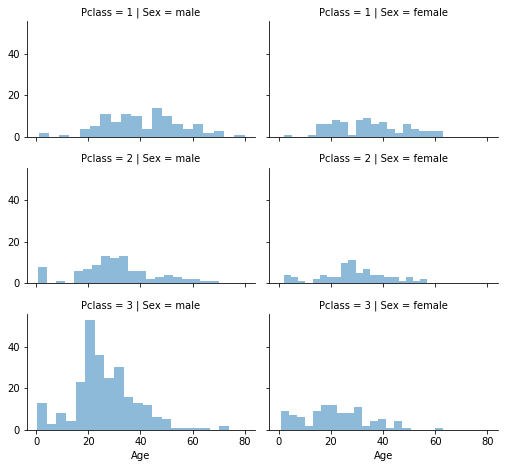

In [24]:
grid = sns.FacetGrid(original_train, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [25]:
# there are 6 combinations, 2 sex * 3 Pclass

guess_ages = np.zeros((2, 3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [26]:
for dataset in full:
    for i in range(0, 2): # based on gender
        for j in range(0, 3): # based on pclass
            guess_df = dataset[(dataset['Sex'] == 0) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            guess_df = dataset[(dataset['Sex'] == 1) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            # Calculate median age of coorelated data
            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int(age_guess/0.5 + 0.5) * 0.5
            
    # Fill the missing value based on their gender and pclass
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == 0) & (dataset.Pclass == j+1), 'Age'] \
                = guess_ages[i,j]
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == 1) & (dataset.Pclass == j+1), 'Age'] \
                = guess_ages[i,j]
            
    dataset['Age'] = dataset['Age'].astype(int)

print(fixed_train['Age'].unique())
print(fixed_test['Age'].unique())

[22 38 26 35 21 54  2 27 14  4 58 20 39 55 28 31 34 15  8 19 40 66 42 18
  3  7 49 29 65  5 11 45 17 32 16 25  0 30 33 23 24 46 59 71 37 47 70 12
  9 36 51 44  1 61 56 50 62 41 52 63 43 60 10 64 13 48 53 57 80  6 74]
[34 47 62 27 22 14 30 26 18 21 46 23 63 24 35 45 55  9 41 48 50 33 25 39
 60 36 20 28 10 17 32 13 31 29  6 67 49  2 76 43 16  1 12 42 53 40 61  7
 15 54 64 37 11  8  0 38 57 19 58 59 44  5 51  3]


After filling the missing age, we can define bins for age and see the correlation between people in different age and their survivability.

Use pd.cut(...)

In [27]:
fixed_train['AgeBand'] = pd.cut(fixed_train['Age'], 5)
fixed_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean() \
    .sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


We can replace the age with cooresponding ageband.

In [28]:
for dataset in full:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
fixed_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,7.2500,NaN,S,"(16.0, 32.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,71.2833,C85,C,"(32.0, 48.0]"
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,7.9250,NaN,S,"(16.0, 32.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,53.1000,C123,S,"(32.0, 48.0]"
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,8.0500,NaN,S,"(32.0, 48.0]"


We can now remove the ageband feature

In [29]:
fixed_train = fixed_train.drop(['AgeBand'], axis=1)
full = [fixed_train, fixed_test]

In [31]:
# We can also combine Pclass and Age features to a new feature Age*Pclass

fixed_train['Age*Pclass'] = fixed_train['Age'] * fixed_train['Pclass']
fixed_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age*Pclass
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,7.2500,NaN,S,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,8.0500,NaN,S,6


In [32]:
# 2. Cabin
original_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [33]:
# Simply fill empty cabin with U - 'Unknown'
for dataset in full:
    dataset['Cabin'].fillna('U', inplace=True)
    
fixed_train['Cabin'].unique()

array(['U', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [34]:
# 3. Embarked
original_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [35]:
# for the port of embark, we will just fill with the most frequent one
freq_embark = original_train['Embarked'].dropna().mode()[0]
freq_embark

'S'

In [36]:
for dataset in full:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_embark)
    
fixed_train[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean().sort_values('Embarked')

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [37]:
for dataset in full:
    try:
        dataset['Embarked'] = dataset['Embarked'].map( {'C': 0, 'Q': 1, 'S': 2} ).astype(int)
    except:
        break
        
fixed_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age*Pclass
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,7.2500,U,2,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,71.2833,C85,0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,7.9250,U,2,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,53.1000,C123,2,2
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,8.0500,U,2,6


In [38]:
# 4. Fare
test['Fare'].unique()

array([  7.8292,   7.    ,   9.6875,   8.6625,  12.2875,   9.225 ,
         7.6292,  29.    ,   7.2292,  24.15  ,   7.8958,  26.    ,
        82.2667,  61.175 ,  27.7208,  12.35  ,   7.225 ,   7.925 ,
        59.4   ,   3.1708,  31.6833,  61.3792, 262.375 ,  14.5   ,
        61.9792,  30.5   ,  21.6792,  31.5   ,  20.575 ,  23.45  ,
        57.75  ,   8.05  ,   9.5   ,  56.4958,  13.4167,  26.55  ,
         7.85  ,  13.    ,  52.5542,  29.7   ,   7.75  ,  76.2917,
        15.9   ,  60.    ,  15.0333,  23.    , 263.    ,  15.5792,
        29.125 ,   7.65  ,  16.1   ,  13.5   ,   7.725 ,  21.    ,
         7.8792,  42.4   ,  28.5375, 211.5   ,  25.7   ,  15.2458,
       221.7792,  10.7083,  14.4542,  13.9   ,   7.775 ,  52.    ,
         7.7958,  78.85  ,   7.8542,  55.4417,   8.5167,  22.525 ,
         7.8208,   8.7125,  15.0458,   7.7792,  31.6792,   7.2833,
         6.4375,  16.7   ,  75.2417,  15.75  ,   7.25  ,  23.25  ,
        28.5   ,  25.4667,  46.9   , 151.55  ,  18.    ,  51.8

In [39]:
fixed_test['Fare'].fillna(fixed_test['Fare'].dropna().median(), inplace=True)
fixed_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,2,0,0,330911,7.8292,U,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,2,1,0,363272,7.0000,U,2
2,894,2,"Myles, Mr. Thomas Francis",0,3,0,0,240276,9.6875,U,1
3,895,3,"Wirz, Mr. Albert",0,1,0,0,315154,8.6625,U,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1,1,1,3101298,12.2875,U,2


In [40]:
# We can create a fare band
# Here we use qcut because the distribution of fare is a little too much right-skewed
fixed_train['FareBand'] = pd.qcut(fixed_train['Fare'], 4)
fixed_train['FareBand']

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
            ...       
886     (7.91, 14.454]
887     (14.454, 31.0]
888     (14.454, 31.0]
889     (14.454, 31.0]
890     (-0.001, 7.91]
Name: FareBand, Length: 891, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [41]:
fixed_train[['FareBand', 'Survived']].groupby('FareBand', as_index=False).mean().sort_values('FareBand')

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


As we can see, people who bought more expensive tickets have a higher chance of surviving.

In [42]:
for dataset in full:    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31.0), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31.0, 'Fare'] = 3
    
    dataset['Fare'] = dataset['Fare'].astype(int)
    
fixed_train = fixed_train.drop(['FareBand'], axis=1)
full = [fixed_train, fixed_test]
    
fixed_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age*Pclass
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0,U,2,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,3,C85,0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,1,U,2,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,3,C123,2,2
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,1,U,2,6


In [43]:
fixed_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,2,0,0,330911,0,U,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,2,1,0,363272,0,U,2
2,894,2,"Myles, Mr. Thomas Francis",0,3,0,0,240276,1,U,1
3,895,3,"Wirz, Mr. Albert",0,1,0,0,315154,1,U,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1,1,1,3101298,1,U,2


## 4.3 Feature Engineering

## 4.3.1 Name

We have explored and cleaned all quantitaive data. Now let's explore nominal data, which is Name.

In [44]:
original_train['Name'][:10]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

We can see that there are different prefixes. They reflect to social status and may affect the survivability.

In [45]:
# Use Regex to extract all titles

import re

pattern = r"(\w+)\."
train_text = ''.join(original_train['Name'].values)
test_text = ''.join(test['Name'].values)

train_titles = pd.Series(re.findall(pattern, train_text))
test_titles = pd.Series(re.findall(pattern, test_text))
train_titles

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Length: 892, dtype: object

In [46]:
# Check all kinds of titles

train_titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'L', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [47]:
# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "Countess":   "Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty",
                    "L" :      "Royalty"
                    }

In [48]:
# Map each prefix to a category

train_titles = pd.Series(train_titles).map(Title_Dictionary)
test_titles = pd.Series(test_titles).map(Title_Dictionary)
train_titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

In [49]:
fixed_train['Title'] = train_titles
fixed_test['Title'] = test_titles
fixed_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.500000
1,Miss,0.543478
2,Mr,0.251938
3,Mrs,0.661417
4,Officer,0.333333
5,Royalty,0.333333


In [50]:
fixed_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age*Pclass,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0,U,2,3,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,3,C85,0,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,1,U,2,3,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,3,C123,2,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,1,U,2,6,Mr


In [51]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royalty": 5, 'Officer': 6}
for dataset in full:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

fixed_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age*Pclass,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0,U,2,3,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,3,C85,0,2,3
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,1,U,2,3,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,3,C123,2,2,3
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,1,U,2,6,1


In [52]:
fixed_train = fixed_train.drop('Name', axis=1)
fixed_test = fixed_test.drop('Name', axis=1)
full = [fixed_train, fixed_test]

## 4.3.2 Ticket Class

In [53]:
original_train['Ticket'][:10]

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [54]:
# Extract the prefix of each ticket. If the ticket only contains digit, return 'N'

def ticket_prefix(ticket_lst):
    prefix = []
    for t in ticket_lst:
        ticket = t.replace('.', '').replace('/', '').split()
        for i in ticket:
            try:
                int(i)
                prefix.append('N')
                break
            except ValueError:
                prefix.append(i)
                break
    return prefix
    
tp = pd.Series(ticket_prefix(original_train['Ticket']))
tp

0          A5
1          PC
2      STONO2
3           N
4           N
        ...  
886         N
887         N
888        WC
889         N
890         N
Length: 891, dtype: object

## 4.3.3 Family Size

SibSp tells us the number of siblings, and Parch tells us the number of parents on board. Based on these information, we can define different sizes of family.

In [55]:
fam_count = fixed_train['SibSp'] + fixed_train['Parch']

# We define 0 as single, 1-3 as small family, >4 as large family
def fam_size(ct):
    if ct == 0:
        return 'Single'
    elif ct > 0 and ct <= 3:
        return 'Small'
    else:
        return 'Large'

fam_count = fam_count.map(fam_size)
fixed_train['FamilySize'] = fam_count
fixed_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean() \
    .sort_values(by='Survived', ascending=False)

,FamilySize,Survived
2,Small,0.578767
1,Single,0.303538
0,Large,0.161290


In [56]:
# We can also look at the family size exactly
for dataset in full:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

fixed_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean() \
    .sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [57]:
# We can create feature called IsAllone
for dataset in full:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

fixed_train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [58]:
# Now we can drop SibSp, Parch, and FamilySize since we have the feature IsAlone

fixed_train = fixed_train.drop(['Parch', 'SibSp'], axis=1)
fixed_test = fixed_test.drop(['Parch', 'SibSp'], axis=1)
full = [fixed_train, fixed_test]

In [59]:
fixed_train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Age*Pclass,Title,FamilySize,IsAlone
0,1,0,3,0,1,A/5 21171,0,U,2,3,1,2,0
1,2,1,1,1,2,PC 17599,3,C85,0,2,3,2,0
2,3,1,3,1,1,STON/O2. 3101282,1,U,2,3,2,1,1
3,4,1,1,1,2,113803,3,C123,2,2,3,2,0
4,5,0,3,0,2,373450,1,U,2,6,1,1,1
5,6,0,3,0,1,330877,1,U,1,3,1,1,1
6,7,0,1,0,3,17463,3,E46,2,3,1,1,1
7,8,0,3,0,0,349909,2,U,2,0,4,5,0
8,9,1,3,1,1,347742,1,U,2,3,3,3,0
9,10,1,2,1,0,237736,2,U,0,0,3,2,0


In [60]:
fixed_test.head(10)

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
0,892,3,0,2,330911,0,U,1,1,1,1
1,893,3,1,2,363272,0,U,2,3,2,0
2,894,2,0,3,240276,1,U,1,1,1,1
3,895,3,0,1,315154,1,U,2,1,1,1
4,896,3,1,1,3101298,1,U,2,3,3,0
5,897,3,0,0,7538,1,U,2,1,1,1
6,898,3,1,1,330972,0,U,1,2,1,1
7,899,2,0,1,248738,2,U,2,1,3,0
8,900,3,1,1,2657,0,U,0,3,1,1
9,901,3,0,1,A/4 48871,2,U,2,1,3,0


<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>

# 5. Model Training

Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forrest
- Perceptron
- Artificial neural network
- RVM or Relevance Vector Machine

## 5.1 Select Variables

It's time to fit our updated logistic regression model which consists of numeric variables and our one-hot-encoded variables.

In [61]:
# # Helper Function for creating final dataframe for model training

# def process_data(data, features):
#     """Process the data for a guided model."""
    
#     try:
#         final_data = data[['Survived']]
#     except:
#         final_data = pd.DataFrame()
    
#     # Pre-process data
#     # Prefix
#     pattern = r"(\w+)\."
#     text = ''.join(data['Name'].values)
#     titles = pd.Series(re.findall(pattern, text))
#     titles = pd.Series(titles).map(Title_Dictionary)
#     data['Title'] = titles
    
#     # Ticket prefix
#     tp = pd.Series(ticket_prefix(data['Ticket']))
#     data['Ticket'] = tp
    
#     # Family size
#     fam_count = data['SibSp'] + data['Parch']
#     fam_count = fam_count.map(fam_size)
#     data['Family'] = fam_count
    
#     # One-hot-encode features
#     numeric = ['Pclass', 'Age', 'Fare']
#     for f in features:
#         if f in numeric:
#             final_data = pd.concat([final_data, data[f]], axis=1)
#             continue
#         try:
#             final_data = pd.concat([final_data, ohe(data, f)], axis=1)
#         except:
#             print('Feature ', f, ' is not available!')
    
#     # return the final dataframe
#     return final_data

In [74]:
def select_columns(data, columns):
    """Select only columns passed as arguments."""
    return data[columns]

,Pclass,Title,Sex,Age,IsAlone,Fare,Embarked,Age*Pclass
0,3,1,0,1,0,0,2,3
1,1,3,1,2,0,3,0,2
2,3,2,1,1,1,1,2,3
3,1,3,1,2,0,3,2,2
4,3,1,0,2,1,1,2,6
...,...,...,...,...,...,...,...,...
886,2,3,0,1,1,1,2,2
887,1,6,1,1,1,2,2,1
888,3,2,1,1,0,2,2,3
889,1,2,0,1,1,2,0,1


The following variables are available for model training:
- Pclass
- Title
- Sex
- Age
- Family
- IsAlone
- Fare
- Embarked
- Age*Pclass
- Ticket **
- Cabin **

** means optional

In [62]:
# Select different features 
features = ['Pclass', 'Title', 'Sex', 'Age', 'IsAlone', 'Fare', 'Embarked', 'Age*Pclass']

print(final_df.drop('Survived', axis=1).shape)
final_df

NameError: name 'final_df' is not defined

In [ ]:
# Split our data to train and test
train = final_df[0:891]
train['Survived'] = train['Survived'].astype(int)
test = final_df[891:]

from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.1, random_state=42)
pd.set_option('display.max_columns', 500)
print(train.drop('Survived', axis=1).shape)
train.head()

In [ ]:
test

In [ ]:
# model = LogisticRegression()
# model = RandomForestClassifier(n_estimators=100)
# model = SVC()
# model = GradientBoostingClassifier()
# model = KNeighborsClassifier(n_neighbors = 3)
# model = GaussianNB()

In [ ]:
X_train, Y_train = train.drop(['Survived'], axis=1), train['Survived']
X_val, Y_val = val.drop(['Survived'], axis=1), val['Survived']

model.fit(X_train, Y_train)
print('Training accuracy: ', model.score(X_train,Y_train))
print('Testing accuracy: ', model.score(X_val,Y_val))

In [ ]:
# def cv():
#     feature = ['Pclass', 'Title', 'Sex', 'Age', 'Family', 'Fare', 'Ticket', 'Cabin', 'Embarked']
#     for features in feature:
#         features = features.split()
#         final_df = process_data(full_data, features)
#         train = final_df[0:891]
#         train['Survived'] = train['Survived'].astype(int)
#         test = final_df[891:]

#         from sklearn.model_selection import train_test_split
#         train, val = train_test_split(train, test_size=0.1, random_state=42)
#         pd.set_option('display.max_columns', 500)
#         X_train, Y_train = train.drop(['Survived'], axis=1), train['Survived']
#         X_val, Y_val = val.drop(['Survived'], axis=1), val['Survived']

#         from sklearn.linear_model import LogisticRegression
#         model = LogisticRegression()
#         model.fit(X_train, Y_train)
#         print('The feature is: ', features)
#         print('Training accuracy: ', model.score(X_train,Y_train))
#         print('Testing accuracy: ', model.score(X_val,Y_val))
#         print()
# cv()

## 6. Predicting on the real data!

In [ ]:
# Predict the real data
print(test.shape)
test.head()

In [ ]:
test_predictions = model.predict(test.drop('Survived', axis=1))
test_predictions = test_predictions.astype(int)
print(test_predictions.size)
test_predictions

In [ ]:
from datetime import datetime

# Construct and save the submission:
submission_df = pd.DataFrame({
    "PassengerId": full_data['PassengerId'][891:], 
    "Survived": test_predictions,
}, columns=['PassengerId', 'Survived'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')